# Homework 1 - Data Wrangling with Hadoop

The goal of this assignment is to put into action the data wrangling techniques from the exercises of week-3 and week-4. We highly suggest you to finish these two exercises first and then start the homework. In this homework, we are going to reuse the same __sbb__ dataset as we see in two exercises. 

Try to use as much as HiveQL as possible and use pandas operations only when it's necessary.

__Hand-in:__
- __Due: 24.03.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your queries readable


__Cluster Usage__

As there are many of you working with the cluster, we encourage you to prototype your queries on small data samples before running them on whole datasets.

__Documentation__

Hive queries: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select>

Hive functions: <https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF>


In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
pd.set_option("display.max_columns", 50)
%matplotlib inline

from pyhive import hive
username = os.environ['JUPYTERHUB_USER']
# create connection
conn = hive.connect(host='iccluster059.iccluster.epfl.ch', port=10000, username=username) 
# create cursor
cur = conn.cursor()

## Data from SBB/CFF/FFS

Data source: <https://opentransportdata.swiss/en/dataset/istdaten>

In this part, you will leverage Hive to perform exploratory analysis of data published by the [Open Data Platform Swiss Public Transport](https://opentransportdata.swiss).

Format: the dataset is originally presented as a collection of textfiles with fields separated by ';' (semi-colon). For efficiency, the textfiles have been compressed into Optimized Row Columnar ([ORC](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+ORC)) file format. 

Location: you can find the data in ORC format on HDFS at the path `/data/sbb/orc/istdaten`.

The full description from opentransportdata.swiss can be found in <https://opentransportdata.swiss/de/cookbook/ist-daten/> in four languages. Because of the translation typos there may be some misunderstandings. We suggest you rely on the German version and use an automated translator when necessary. We will clarify if there is still anything unclear in class and Slack. Here are the relevant column descriptions:

- `BETRIEBSTAG`: date of the trip
- `FAHRT_BEZEICHNER`: identifies the trip
- `BETREIBER_ABK`, `BETREIBER_NAME`: operator (name will contain the full name, e.g. Schweizerische Bundesbahnen for SBB)
- `PRODUKT_ID`: type of transport, e.g. train, bus
- `LINIEN_ID`: for trains, this is the train number
- `LINIEN_TEXT`,`VERKEHRSMITTEL_TEXT`: for trains, the service type (IC, IR, RE, etc.)
- `ZUSATZFAHRT_TF`: boolean, true if this is an additional trip (not part of the regular schedule)
- `FAELLT_AUS_TF`: boolean, true if this trip failed (cancelled or not completed)
- `HALTESTELLEN_NAME`: name of the stop
- `ANKUNFTSZEIT`: arrival time at the stop according to schedule
- `AN_PROGNOSE`: actual arrival time
- `AN_PROGNOSE_STATUS`: show how the actual arrival time is calcluated
- `ABFAHRTSZEIT`: departure time at the stop according to schedule
- `AB_PROGNOSE`: actual departure time
- `AB_PROGNOSE_STATUS`: show how the actual departure time is calcluated
- `DURCHFAHRT_TF`: boolean, true if the transport does not stop there

Each line of the file represents a stop and contains arrival and departure times. When the stop is the start or end of a journey, the corresponding columns will be empty (`ANKUNFTSZEIT`/`ABFAHRTSZEIT`).

In some cases, the actual times were not measured so the `AN_PROGNOSE_STATUS`/`AB_PROGNOSE_STATUS` will be empty or set to `PROGNOSE` and `AN_PROGNOSE`/`AB_PROGNOSE` will be empty.

### Get yourself ready

If you have gone through the exercises by yourself, you are free to go for the questions. If you haven't gone through the exercises, you can follow the next two cells to get all your databases and tables ready.

__In Shell__:

```bash
hdfs dfs -mkdir   -p                              /user/chahed/hive

hdfs dfs -setfacl -m    user:hive:r-x             /user/chahed

hdfs dfs -setfacl -R -m group::r-x                /user/chahed

hdfs dfs -setfacl -R -m other::---                /user/chahed

hdfs dfs -setfacl -R -m default:group::r-x        /user/chahed

hdfs dfs -setfacl -R -m default:other::---        /user/chahed

hdfs dfs -setfacl -m    user:hive:rwx             /user/chahed/hive

hdfs dfs -setfacl -m    default:user:hive:rwx     /user/chahed/hive
```

In [2]:
# Drop your database
query = """
    drop database if exists {0} cascade
""".format(username)
cur.execute(query)

# Create your database
query = """
    create database {0} location "/user/{0}/hive"
""".format(username)
cur.execute(query)

# Drop the sbb table
query = """
    drop table if exists {0}.sbb_orc
""".format(username)
cur.execute(query)

# Create the sbb table
query = """
    create external table {0}.sbb_orc(
        BETRIEBSTAG string,
        FAHRT_BEZEICHNER string,
        BETREIBER_ID string,
        BETREIBER_ABK string,
        BETREIBER_NAME string,
        PRODUKT_ID string,
        LINIEN_ID string,
        LINIEN_TEXT string,
        UMLAUF_ID string,
        VERKEHRSMITTEL_TEXT string,
        ZUSATZFAHRT_TF string,
        FAELLT_AUS_TF string,
        BPUIC string,
        HALTESTELLEN_NAME string,
        ANKUNFTSZEIT string,
        AN_PROGNOSE string,
        AN_PROGNOSE_STATUS string,
        ABFAHRTSZEIT string,
        AB_PROGNOSE string,
        AB_PROGNOSE_STATUS string,
        DURCHFAHRT_TF string
    )
    row format delimited fields terminated by ';'
    stored as ORC
    location '/data/sbb/orc/istdaten'
    tblproperties ("skip.header.line.count"="1")
""".format(username)
cur.execute(query)

# Drop the table of one day
query = """
    drop table if exists {0}.sbb_05_11_2018
""".format(username)
cur.execute(query)

# Create the table of one day
query = """
    create table {0}.sbb_05_11_2018
    stored as orc
    as 
        select *
        from {0}.sbb_orc
        where BETRIEBSTAG like '05_11_2018'
""".format(username)
cur.execute(query)

### Question I.a - 5 Points

In the exercise, you were asked to find how many stops of each type of transportation for the date 05.11.2018. Now, let's do the same for the whole dataset. 

Show the results with a stacked bar chart (you can use `pandas` to create a pivot table if necessary). Document any patterns you can see.

__Hint__: 
- To properly order by date, you may have to parse them using the `unix_timestamp` function.
- When using `pd.read_sql(query, conn, ...)` to retrieve the query results, there is one `parse_dates` argument for date parsing.
- If you think it is not nice to display all the data in one plot, you can select a small period of data, i.e. 3 months, for visualization to detect the pattern.

In [3]:
# Drop the table of one day
query = """
    drop table if exists {0}.days_count_orc
""".format(username)
cur.execute(query)

query = """
    create table {0}.days_count_orc
    stored as orc
    as 
        select lower(PRODUKT_ID) as ttype, BETRIEBSTAG as dates, count(*) as stops
        from {0}.sbb_orc
        group by lower(PRODUKT_ID), BETRIEBSTAG
""".format(username)
cur.execute(query)

***In the meantime, limit the queries to return less than 500 rows. You do not need more than that for the homework.
We are rephrasing the question to limit it to 1 month in 2018 and 1 month in 2019. Please document any daily pattern or “trend” you find out.***

In [5]:
query = """
    select ttype, dates, stops
    from {0}.days_count_orc 
    where dates like '%01_2018' or dates like '%01_2019'
    order by unix_timestamp (dates ,  'dd.MM.yyy')
""""".format(username)

df_type = pd.read_sql(query, conn,  parse_dates = {'dates' : {'dayfirst': True} } )
df_type

,ttype,dates,stops
0,schiff,2018-01-01,162
1,bus,2018-01-01,340125
2,tram,2018-01-01,125158
3,zug,2018-01-01,131364
4,bus,2018-01-02,360573
...,...,...,...
262,schiff,2019-01-31,194
263,zug,2019-01-31,156577
264,bus,2019-01-31,958832
265,,2019-01-31,120


In [6]:
df_type.replace('', 'unknown', inplace=True)

In [7]:
pivot_df = df_type.pivot(index='dates', columns='ttype', values='stops').fillna(0)
pivot_df.head(10)

ttype,bus,schiff,tram,unknown,zug
dates,,,,,
2018-01-01,340125.0,162.0,125158.0,0.0,131364.0
2018-01-02,360573.0,162.0,143339.0,0.0,130230.0
2018-01-03,556788.0,167.0,178624.0,0.0,152346.0
2018-01-04,557200.0,167.0,178560.0,0.0,150727.0
2018-01-05,564532.0,175.0,183101.0,0.0,151714.0
2018-01-06,461098.0,163.0,166093.0,0.0,139899.0
2018-01-07,340346.0,162.0,126191.0,0.0,130329.0
2018-01-08,563977.0,167.0,179660.0,0.0,150229.0
2018-01-09,562301.0,167.0,180195.0,0.0,150485.0


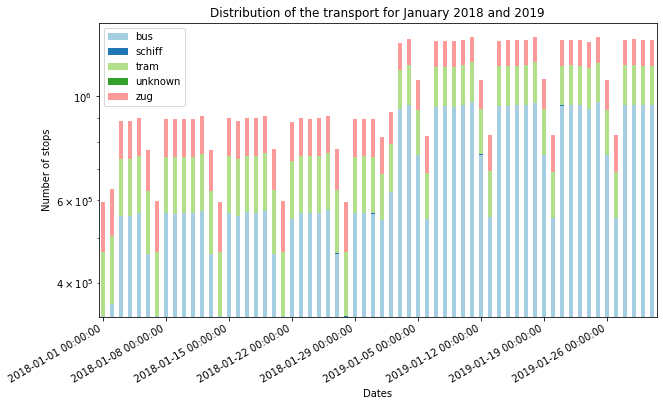

In [8]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10,6))

pal = sns.color_palette("Paired")

pivot_df.plot.bar(stacked=True, ax=ax,legend=True, logy=True, color=pal)

ax.set_xticks(ax.get_xticks()[::7])
ax.set_xticklabels(pivot_df.index[::7])
f.autofmt_xdate()
ax.legend(loc = 0)
plt.xlabel('Dates')
plt.ylabel('Number of stops')
plt.title('Distribution of the transport for January 2018 and 2019')
plt.show()

**We observe that the bus is by far the mean of transport that has the most stops followed by the tram and the train. 
Something that is interesting to note is that in the *Sundays of January 2018* the bus weren't circulating while they are in 2019 but with less stops that during the week. Moreover, we observe a significant increase in bus traffic between the two years (almost doubled) whereas train and tram stops slightly decreased**

### Question I.b - 10 Points

Get the set of IC (`VERKEHRSMITTEL_TEXT`) trains you can take to go (without connections) from Genève to Lausanne on a typical week day (not Saturday, not Sunday, not a bank holiday). Display the train number (`LINIEN_ID`) as well as the schedule of the trains.

__Note:__ do not hesitate to create intermediary tables. You can use the advanced search of SBB's website to check your answer, the schedule of IC from Genève to Lausanne has not changed.

In [9]:
query = """
    drop table if exists {0}.sbb_lau_ic_orc
""".format(username)
cur.execute(query)

# IC trains stopping at Lausanne not special and not in the week-end
# Saturday = 6 and Sunday = 7

query = """
    create table {0}.sbb_lau_ic_orc
    stored as orc
    as
        select *
        from {0}.sbb_orc
        where VERKEHRSMITTEL_TEXT like 'IC' and HALTESTELLEN_NAME like 'Lausanne' 
        and ZUSATZFAHRT_TF like 'false' and AN_PROGNOSE != ''
        and date_format(from_unixtime(unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm')) , 'u') != 6
        and date_format(from_unixtime(unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm')) , 'u') != 7  
""".format(username)
cur.execute(query)

In [10]:
query = """
    drop table if exists {0}.sbb_gnv_ic_orc
""".format(username)
cur.execute(query)

# IC trains stopping at Genève not special and not in the week-end
# Saturday = 6 and Sunday = 7

query = """
    create table {0}.sbb_gnv_ic_orc
    stored as orc
    as
        select * 
        from {0}.sbb_orc
        where VERKEHRSMITTEL_TEXT like 'IC' and HALTESTELLEN_NAME like 'Genève' 
        and ZUSATZFAHRT_TF like 'false' and AB_PROGNOSE != ''
        and date_format(from_unixtime(unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm')) , 'u') != 6
        and date_format(from_unixtime(unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm')) , 'u') != 7  
""".format(username)
cur.execute(query)

In [11]:
# The ic trains that go from Genève to Lausanne
# with the same id and on the same day
# with the real time departure from Geneve before the arrival in Lausanne

query = """
    select distinct GNV.LINIEN_ID as line, 
    date_format(from_unixtime(unix_timestamp(GNV.ABFAHRTSZEIT, 'dd.MM.yyy HH:mm')) , 'EEE HH:mm') as departure,
    date_format(from_unixtime(unix_timestamp(LAU.ANKUNFTSZEIT, 'dd.MM.yyy HH:mm')) , 'EEE HH:mm') as arrival
    from {0}.sbb_gnv_ic_orc GNV join {0}.sbb_lau_ic_orc as LAU
    on (GNV.FAHRT_BEZEICHNER = LAU.FAHRT_BEZEICHNER)
    and GNV.AB_PROGNOSE < LAU.AN_PROGNOSE 
    and GNV.BETRIEBSTAG = LAU.BETRIEBSTAG
""".format(username)

df_gnv_to_lau = pd.read_sql(query, conn )
df_gnv_to_lau

,line,departure,arrival
0,707,Fri 05:42,Fri 06:18
1,707,Thu 05:42,Thu 06:18
2,707,Tue 05:42,Tue 06:18
3,707,Wed 05:42,Wed 06:18
4,709,Fri 06:42,Fri 07:18
...,...,...,...
75,735,Mon 19:42,Mon 20:18
76,735,Wed 19:42,Wed 20:18
77,737,Thu 20:42,Thu 21:18
78,737,Tue 20:42,Tue 21:18


**After verification on the SBB website, it seems that the correct schedule of the IC train from Genève to Lausanne was obtained.**

### Question I.c - 10 Points

In the exercise, we discussed a little bit about two interesting status, `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`. We will continue here to see how things evolved in the past two years.

i) Please show us how the monthly distribution of `AN_PROGNOSE_STATUS` (arrival forcast status) for __IC 733__ train at the Lausanne station changes over time, i.e., how many of them are REAL, GESCHAETZT, etc. in every month. Use `pandas` to create a pivot table if necessary.

In [19]:
query = """
    select AN_PROGNOSE_STATUS as dstatus,
    date_format(from_unixtime(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyy')) , 'MMM yy') as months, count(*) as count
    from {0}.sbb_orc
    where LINIEN_ID like '733' and  VERKEHRSMITTEL_TEXT like 'IC'
    and HALTESTELLEN_NAME like 'Lausanne' 
    group by AN_PROGNOSE_STATUS, date_format(from_unixtime(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyy')) , 'MMM yy')
""".format(username)

df_status = pd.read_sql(query, conn)
df_status.head()

,dstatus,months,count
0,REAL,Feb 19,26
1,REAL,Nov 18,29
2,GESCHAETZT,Mar 18,28
3,PROGNOSE,Mar 19,2
4,GESCHAETZT,Feb 18,27


In [20]:
# Order the dataframe by date and setting the month as index
ordered_month = pd.to_datetime(df_status.months, format='%b %y').sort_values().index.values
df_status = df_status.iloc[ordered_month]
df_status.set_index('months',inplace = True)
df_status.head()

,dstatus,count
months,,
Jan 18,GESCHAETZT,30
Jan 18,PROGNOSE,1
Feb 18,GESCHAETZT,27
Feb 18,PROGNOSE,1
Mar 18,REAL,1


In [21]:
# Pivot the dataframe to restructure it
df_status_pivot = df_status.pivot(columns='dstatus', values='count').fillna(0)
df_status_pivot = df_status_pivot.loc[df_status.index.values]
df_status_pivot.head()

dstatus,GESCHAETZT,PROGNOSE,REAL
months,,,
Jan 18,30.0,1.0,0.0
Jan 18,30.0,1.0,0.0
Feb 18,27.0,1.0,0.0
Feb 18,27.0,1.0,0.0
Mar 18,28.0,2.0,1.0


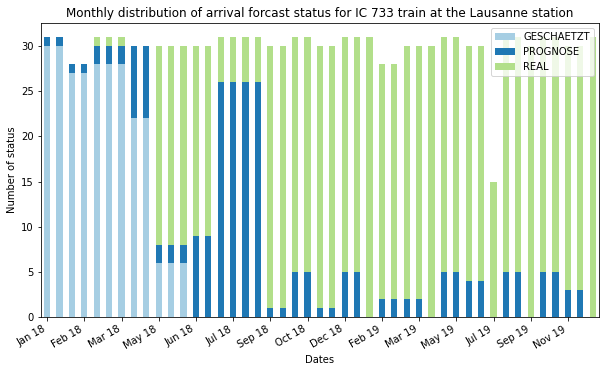

In [22]:
f, ax = plt.subplots(figsize=(10,6))

pal = sns.color_palette("Paired")

df_status_pivot.plot.bar(stacked=True, ax=ax,legend=True,  color=pal)

ax.set_xticks(ax.get_xticks()[::3])
ax.set_xticklabels(df_status_pivot.index[::3])
f.autofmt_xdate()
ax.legend(loc = 0)
plt.xlabel('Dates')
plt.ylabel('Number of status')
plt.title('Monthly distribution of arrival forcast status for IC 733 train at the Lausanne station')
plt.show()

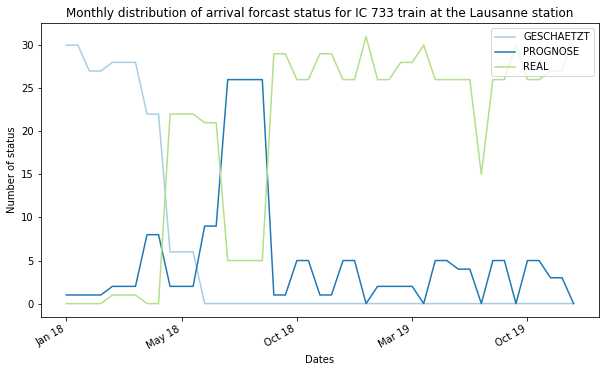

In [23]:
f, ax = plt.subplots(figsize=(10,6))

pal = sns.color_palette("Paired")

df_status_pivot.plot(ax=ax,legend=True,  color=pal)

f.autofmt_xdate()
ax.legend(loc = 1)
plt.xlabel('Dates')
plt.ylabel('Number of status')
plt.title('Monthly distribution of arrival forcast status for IC 733 train at the Lausanne station')
plt.show()

**It seems that for almost the hole year 2018 (until October), the prevailing status was alternating between `Real` (real), `Prognose` (forecast) and `Geschaetzt` (estimated), showing that the accuracy in the time arrival estimation wasn't constant. However, a high percentage of the IC 733 train were marked as `Real` for the arrival forcast status in the following year, which means that this accuracy has increased in 2019.**

ii) Show how the monthly distribution of `AN_PROGNOSE_STATUS` for all the trains that arrived at Lausanne station. Document any anything you observed.

In [25]:
query = """
    select AN_PROGNOSE_STATUS as dstatus,
    date_format(from_unixtime(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyy')) , 'MMM yy') as months, count(*) as count
    from {0}.sbb_orc
    where  PRODUKT_ID like 'Zug' and HALTESTELLEN_NAME like 'Lausanne' 
    group by AN_PROGNOSE_STATUS, date_format(from_unixtime(unix_timestamp(BETRIEBSTAG, 'dd.MM.yyy')) , 'MMM yy')
""".format(username)

df_status_all_train = pd.read_sql(query, conn)
df_status_all_train.head()

,dstatus,months,count
0,PROGNOSE,Oct 18,4772
1,PROGNOSE,May 19,4048
2,PROGNOSE,Nov 19,4079
3,REAL,Jun 18,11760
4,UNBEKANNT,Dec 19,1


In [26]:
# Order the dataframe by date and setting the month as index
ordered_month_all_train = pd.to_datetime(df_status_all_train.months, format='%b %y').sort_values().index.values
df_status_all_train = df_status_all_train.iloc[ordered_month_all_train]
df_status_all_train.set_index('months',inplace = True)
df_status_all_train.head()

,dstatus,count
months,,
Jan 18,UNBEKANNT,2
Jan 18,PROGNOSE,3595
Jan 18,GESCHAETZT,13208
Feb 18,UNBEKANNT,2
Feb 18,GESCHAETZT,12017


In [27]:
# Pivot the dataframe to restructure it
df_status_pivot_all_train = df_status_all_train.pivot(columns='dstatus', values='count').fillna(0)
df_status_pivot_all_train = df_status_pivot_all_train.loc[df_status_all_train.index.values]
df_status_pivot_all_train.head()

dstatus,GESCHAETZT,PROGNOSE,REAL,UNBEKANNT
months,,,,
Jan 18,13208.0,3595.0,0.0,2.0
Jan 18,13208.0,3595.0,0.0,2.0
Jan 18,13208.0,3595.0,0.0,2.0
Feb 18,12017.0,3270.0,0.0,2.0
Feb 18,12017.0,3270.0,0.0,2.0


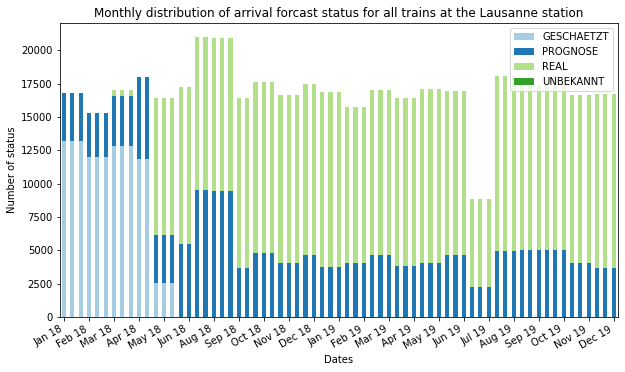

In [28]:
f, ax = plt.subplots(figsize=(10,6))

pal = sns.color_palette("Paired")

df_status_pivot_all_train.plot.bar(stacked=True, ax=ax,legend=True,  color=pal)

ax.set_xticks(ax.get_xticks()[::3])
ax.set_xticklabels(df_status_pivot_all_train.index[::3])
f.autofmt_xdate()
ax.legend(loc = 1)
plt.xlabel('Dates')
plt.ylabel('Number of status')
plt.title('Monthly distribution of arrival forcast status for all trains at the Lausanne station')
plt.show()

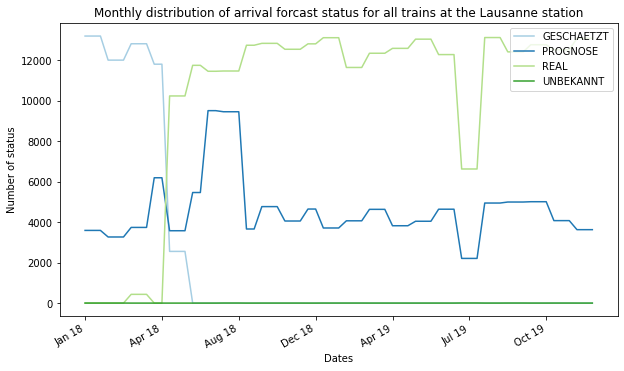

In [29]:
f, ax = plt.subplots(figsize=(10,6))

pal = sns.color_palette("Paired")

df_status_pivot_all_train.plot(ax=ax,legend=True,  color=pal)

f.autofmt_xdate()
ax.legend(loc = 1)
plt.xlabel('Dates')
plt.ylabel('Number of status')
plt.title('Monthly distribution of arrival forcast status for all trains at the Lausanne station')
plt.show()

**Firstly, since now all the trains are taken into account and not only the IC 733, there is much more data to deal with, meaning that one can have a more accurate idea on the arrival forecast status of trains in Lausanne.**

**Secondly, there is a new status that wasn't appearing in the previous plots (IC 733): `Unbekannt` (unknown). Although not so many trains have this status, it shows that some of them seem to have a delay that can't be estimated. Thus even if the IC 733's arrival time isn't always real, it is still never denoted as unknown.**

**Now for the general status trend, one can observe that apart from the first months of 2018 (January to April), the prevailing status for the trains is `Real`, which shows that SBB are generally quite accurate regarding the knowledge of the time at which trains arrive at Lausanne.**

**Globally we observe the same evolution, that is the replacement of the Geschaetzt (estimated) status by the REAL status starting in May 2018 and also a global drop of the number of status in July 2019**

### Question I.d - 20 Points

In this question, use __REAL__ for `AN_PROGNOSE_STATUS` and `AB_PROGNOSE_STATUS`.

i) Display the distribution of delays for the __IC 733__ train at the Lausanne train station. Select the information from the database as a "histogram" with bin size of one minute and plot it in a proper way.

__Note:__ when the train is ahead of schedule, count this as a delay of 0.

In [5]:
# Delay for the arrival time
query = """
    with arrival_times as(
        select unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm') as expected, 
               unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual
        from {0}.sbb_orc
        where LINIEN_ID like '733' and  VERKEHRSMITTEL_TEXT like 'IC'
        and HALTESTELLEN_NAME like 'Lausanne' and AN_PROGNOSE_STATUS like 'REAL'
    )
    select  minute( from_unixtime( greatest(actual - expected, 0) ) ) as delay, count(*) as counts
    from arrival_times
    group by minute(from_unixtime( greatest(actual - expected, 0) ) )
    order by delay
""".format(username)

df_delay_arrival = pd.read_sql(query, conn)
df_delay_arrival.head()

,delay,counts
0,0,305
1,1,67
2,2,39
3,3,28
4,4,13


In [6]:
df_delay_arrival.set_index('delay',inplace = True)

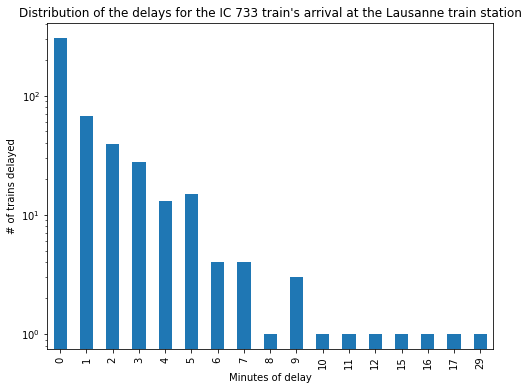

In [42]:
df_delay_arrival.plot(kind= 'bar', figsize = (8,6), logy = True, legend = False)
plt.title("Distribution of the delays for the IC 733 train's arrival at the Lausanne train station")
plt.ylabel("# of trains delayed")
plt.xlabel("Minutes of delay")
plt.show()

In [8]:
# Delay for the departure time
query = """
    with arrival_times as(
        select unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm') as expected, 
               unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') as actual
        from {0}.sbb_orc
        where LINIEN_ID like '733' and  VERKEHRSMITTEL_TEXT like 'IC'
        and HALTESTELLEN_NAME like 'Lausanne' and AB_PROGNOSE_STATUS like 'REAL'
    )
    select  minute( from_unixtime( greatest(actual - expected, 0) ) ) as delay, count(*) as counts
    from arrival_times
    group by minute(from_unixtime( greatest(actual - expected, 0) ) )
    order by delay
""".format(username)

df_delay_departure = pd.read_sql(query, conn)
df_delay_departure.head()

,delay,counts
0,0,97
1,1,204
2,2,80
3,3,58
4,4,18


In [9]:
df_delay_departure.set_index('delay',inplace = True)

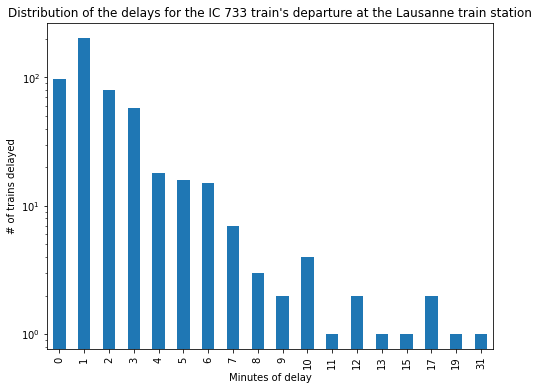

In [41]:
df_delay_departure.plot(kind= 'bar', figsize = (8,6), logy = True, legend = False)
plt.title("Distribution of the delays for the IC 733 train's departure at the Lausanne train station")
plt.ylabel("# of trains delayed")
plt.xlabel("Minutes of delay")
plt.show()

**A first observation that could be expected, the higher the delay, the lower the number of delayed trains.**

**However, the peak for the train's arrival is at 0 min of delay, whereas it is at 1 min for the departures, and it seems that generally there are more delayed trains at departure than arrival.
The arrival delay peak at 0 can be explained by the fact that some trains arrive earlier than scheduled  as they can catch up the departure delay during they journey, for instance by having shorter stops at each station, which makes it still arrive on or before time even with an initial delay.**

ii) Compute the 50th and 75th percentiles of delays for IC 702, 704, ..., 728, 730 (15 trains total) at Genève main station. Which trains are the most disrupted? Can you find the tendency and interpret?

In [126]:
query = """
    drop table if exists {0}.sbb_gnv_ic_del
""".format(username)
cur.execute(query)


query = """
    create table {0}.sbb_gnv_ic_del
    stored as orc
    as
        select * 
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Genève' and  VERKEHRSMITTEL_TEXT like 'IC' 
        and (LINIEN_ID like '702' or LINIEN_ID like '704' or LINIEN_ID like '706' or LINIEN_ID like '708' or LINIEN_ID like '710'
        or LINIEN_ID like '712' or LINIEN_ID like '714' or LINIEN_ID like '716' or LINIEN_ID like '718' or LINIEN_ID like '720'
        or LINIEN_ID like '722' or LINIEN_ID like '724' or LINIEN_ID like '726' or LINIEN_ID like '728' or LINIEN_ID like '730') 
""".format(username)
cur.execute(query)

**Let's first have a basic idea of the global delay distributions.**

In [3]:
# Train's departure delay 
query = """
    select greatest( unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'), 0)  as delay,
    LINIEN_ID as line
    from {0}.sbb_gnv_ic_del
    where ABFAHRTSZEIT != ''
""".format(username)

df_dep_delay_gnv = pd.read_sql(query, conn)
df_dep_delay_gnv.head()

,delay,line
0,262.0,702
1,229.0,704
2,70.0,706
3,491.0,708
4,71.0,710


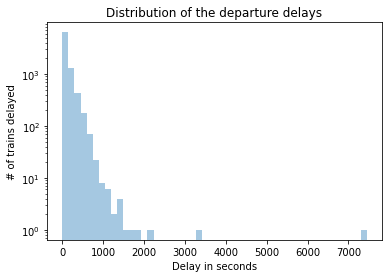

In [69]:
ax = sns.distplot(df_dep_delay_gnv.delay, kde=False)
ax.set_yscale('log')
plt.xlabel('Delay in seconds')
plt.ylabel('# of trains delayed')
plt.title('Distribution of the departure delays')
plt.show()

In [667]:
# Train's arrival delay 
query = """
    select greatest( unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm'), 0)  as delay,
    LINIEN_ID as line
    from {0}.sbb_gnv_ic_del
    where ANKUNFTSZEIT != ''
""".format(username)

df_arrival_delay_gnv = pd.read_sql(query, conn)
df_arrival_delay_gnv.head()

,delay,line
0,87.0,702
1,133.0,704
2,0.0,706
3,589.0,708
4,276.0,710


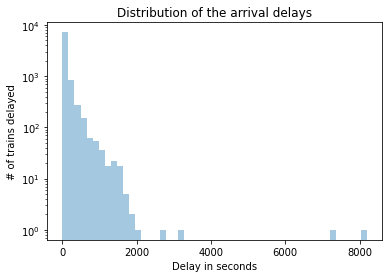

In [669]:
ax = sns.distplot(df_arrival_delay_gnv.delay, kde=False)
ax.set_yscale('log')
plt.xlabel('Delay in seconds')
plt.ylabel('# of trains delayed')
plt.title('Distribution of the arrival delays')
plt.show()

In [670]:
# Train's arrival and departure delay 
df_delay_gnv = pd.concat([df_dep_delay_gnv, df_arrival_delay_gnv])
df_delay_gnv.head()

,delay,line
0,262.0,702
1,229.0,704
2,70.0,706
3,491.0,708
4,71.0,710


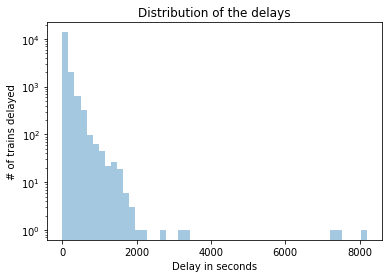

In [672]:
ax = sns.distplot(df_delay_gnv.delay,  kde=False)
ax.set_yscale('log')
plt.xlabel('Delay in seconds')
plt.ylabel('# of trains delayed')
plt.title('Distribution of the delays')
plt.show()

In [673]:
df_delay_gnv.describe()

,delay
count,17120.000000
mean,113.242114
std,200.474694
min,0.000000
25%,17.000000
50%,60.000000
75%,128.000000
max,8191.000000


**Now let's look at the delay distribution for each train separately.**

In [685]:
def grouped_hist(data_dep, data_arv, feature, group):
    unique_vals = data_dep[group].unique().astype(int)
    unique_vals.sort()
    unique_vals = unique_vals.astype(str)
    
    fig , ax = plt.subplots(nrows=5, ncols=3,figsize=(20,20) )
     
    for i in range(2):
        if(i == 0):
            targets = [data_dep.loc[data_dep[group] == val] for val in unique_vals]
            l = ' departure delay'
        else: 
            targets = [data_arv.loc[data_arv[group] == val] for val in unique_vals]
            l = ' arrival delay'
        for ind, target in enumerate(targets):
            col = ind % 3
            row = int(ind / 3)

            data_line = target[feature]
            sns.distplot(target[feature] , kde=False, label= target[group]+l, ax = ax[row, col])

            plt.xlabel('Delay in seconds')
            ax[row, col].legend()
            ax[row, col].set_xlim(-100, 3500)
            ax[row, col].set_yscale('log')
            ax[row, col].set_xlabel('Delay in seconds')
            ax[row, col].set_ylabel('# of trains delayed')

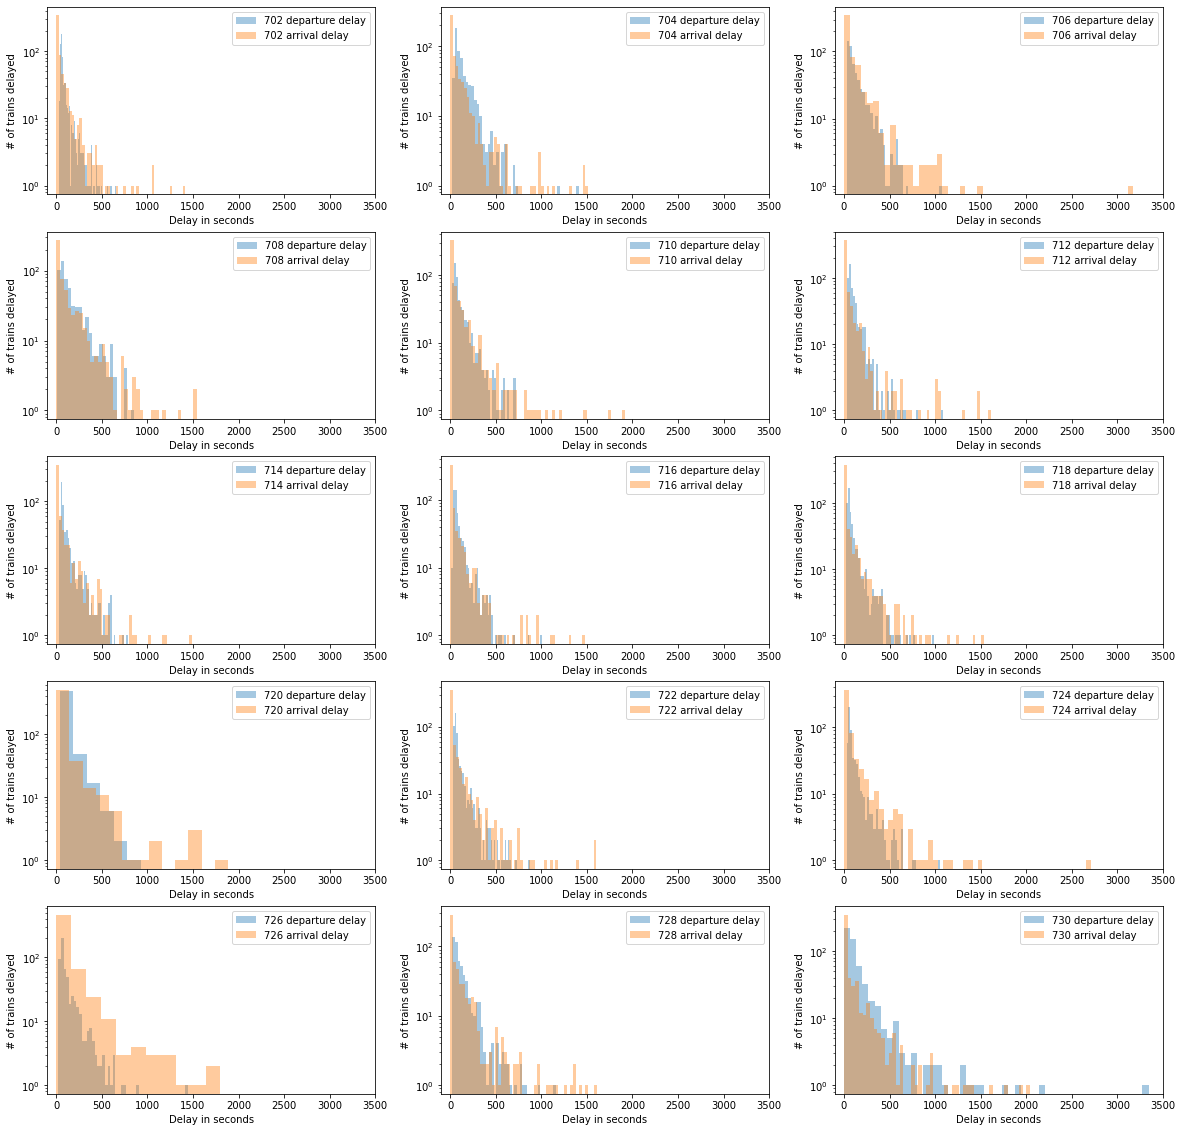

In [686]:
grouped_hist(df_dep_delay_gnv, df_arrival_delay_gnv, 'delay', 'line')

**Let's finally analyze the first quartile and median for these delay distributions.**

In [5]:
# Train's departure delay percentile
query = """
    select LINIEN_ID as line, 
    sum( greatest( unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'), 0) )  as delays,
    percentile( greatest( unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'), 0), 0.5 ) as median,
    percentile( greatest( unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'), 0), 0.75 ) as 3quartiles 
    from {0}.sbb_gnv_ic_del
    where ABFAHRTSZEIT != ''
    group by LINIEN_ID
    order by delays
""".format(username)

df_dep_delay_gnv_perc = pd.read_sql(query, conn)
df_dep_delay_gnv_perc.set_index('line', inplace=True)
df_dep_delay_gnv_perc.sort_values(by=['median'], inplace = True, ascending = False)

df_dep_delay_gnv_perc.head()

,delays,median,3quartiles
line,,,
708,91525,107.5,220.75
704,85510,103.0,190.50
706,81848,95.0,179.50
728,77979,87.0,171.00
712,67732,80.0,135.50


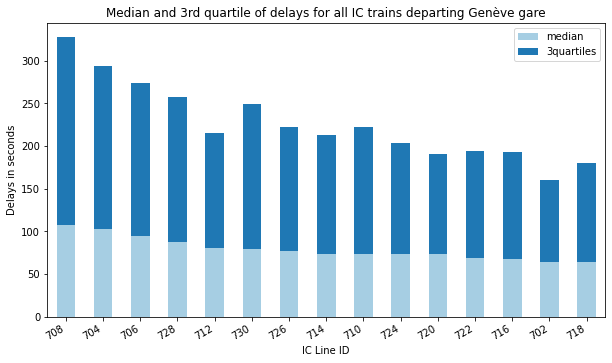

In [16]:
f, ax = plt.subplots(figsize=(10,6))

pal = sns.color_palette("Paired")

df_dep_delay_gnv_perc[['median','3quartiles',]].plot.bar(stacked=True, ax=ax,legend=True,  color=pal)

ax.set_xticks(ax.get_xticks()[::1])
ax.set_xticklabels(df_dep_delay_gnv_perc[['median','3quartiles']].index[::1])
f.autofmt_xdate()
ax.legend(loc = 1)
plt.xlabel('IC Line ID')
plt.ylabel('Delays in seconds')
plt.title('Median and 3rd quartile of delays for all IC trains departing Genève gare')
plt.show()

In [10]:
# Train's arrival delay percentile
query = """
    select LINIEN_ID as line, 
    sum( greatest( unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm'), 0) )  as delays,
    percentile( greatest( unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm'), 0), 0.5 ) as median,
    percentile( greatest( unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm'), 0), 0.75 ) as 3quartiles 
    from {0}.sbb_gnv_ic_del
    where ANKUNFTSZEIT != ''
    group by LINIEN_ID
    order by delays
""".format(username)
df_arr_delay_gnv_perc = pd.read_sql(query, conn)
df_arr_delay_gnv_perc.set_index('line', inplace=True)
df_arr_delay_gnv_perc.sort_values(by=['median'], inplace = True, ascending = False)

df_arr_delay_gnv_perc.head()

,delays,median,3quartiles
line,,,
708,77841,49.0,175.0
726,73502,38.5,126.0
706,66795,37.0,134.5
704,61964,36.0,125.5
728,69522,33.5,139.0


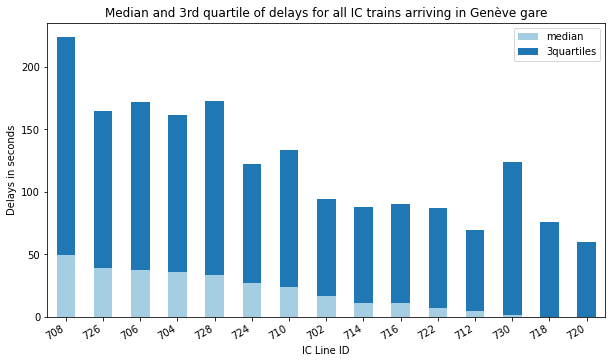

In [17]:
f, ax = plt.subplots(figsize=(10,6))

pal = sns.color_palette("Paired")

df_arr_delay_gnv_perc[['median','3quartiles']].plot.bar(stacked=True, ax=ax,legend=True,  color=pal)

ax.set_xticks(ax.get_xticks()[::1])
ax.set_xticklabels(df_arr_delay_gnv_perc[['median','3quartiles']].index[::1])
f.autofmt_xdate()
ax.legend(loc = 1)
plt.xlabel('IC Line ID')
plt.ylabel('Delays in seconds')
plt.title('Median and 3rd quartile of delays for all IC trains arriving in Genève gare')
plt.show()

**We seperate the delays by the nature of the train, is it a departing or an arriving train ? What stands out is that  the departing trains have almost the same median and small differences in the third quartile depending of the train line. Meanwhile the arriving train delay have more disparate distribution across the train lines with totally different percentiles, therefore we take this delay is a good estimator to gauge which trains are most disrupted.**

**The lines 708, 726, 706, 704, 728, 724 especially are disrupted**

**We check in this website : https://www.vagonweb.cz/razeni/razeni.php?zeme=SBB&kategorie=IC&rok=2019&s=2 the schedule of these lines:**  

**-708 :St. Gallen 06:25 - Winterthur 07:01-07:03 - Zürich Flughafen 07:16-07:18 - Zürich HB 07:27-07:32 - Bern 08:28-08:34 - Lausanne 09:40-09:42 - Genéve 10:18-10:20 - Genéve Aéroport 10:27**

**-726 : St. Gallen 15:25 - Winterthur 16:01-16:03 - Zürich Flughafen 16:16-16:18 - Zürich HB 16:27-16:32 - Bern 17:28-17:34 - Lausanne 18:40-18:42 - Genéve 19:18-19:20 - Genéve Aéroport 19:27**

**-706: St. Gallen 05:04 - Winterthur 05:52-05:54 - Zürich Flughafen 06:07-06:09 - Zürich HB 06:21-06:32 - Bern 07:28-07:34 - Lausanne 08:40-08:42 - Genéve 09:18-09:20 - Genéve Aéroport 09:27**

**-704 : Zürich HB 05:19 - Bern 06:28-06:34 - Lausanne 07:40-07:42 - Genéve 08:18-08:20 - Genéve Aéroport 08:27**

**We observe that these time slots are rush hours which explains why they are distrupted.**

iii) Compute 25th, 50th and 75th percentiles of delays for all trains departing Lausanne gare within each hour and visualize your results. Can you find the tendency and interpret?

In [677]:
 query = """
    drop table if exists {0}.sbb_lau_train_dep
""".format(username)
cur.execute(query)

# Trains departing Lausanne 
query = """
    create table {0}.sbb_lau_train_dep
    stored as orc
    as
        select *
        from {0}.sbb_orc
        where HALTESTELLEN_NAME like 'Lausanne' and  PRODUKT_ID like 'Zug'
        and ABFAHRTSZEIT != ''
""".format(username)
cur.execute(query)

In [678]:
# Train's departure delay percentile
query = """
    select hour(from_unixtime(unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'))) as hours, 
    sum( greatest( unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'), 0) )  as delays,
    percentile( greatest( unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'), 0), 0.25 ) as quartile, 
    percentile( greatest( unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'), 0), 0.5 ) as median, 
    percentile( greatest( unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'), 0), 0.75 ) as 3quartiles, 
    count(*) as counts
    from {0}.sbb_lau_train_dep
    group by hour(from_unixtime(unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm')))
    order by hours
""".format(username)
df_dep_delay_lau_hour = pd.read_sql(query, conn)
df_dep_delay_lau_hour.head()

,hours,delays,quartile,median,3quartiles,counts
0,0,872773,48.00,79.0,189.0,5944
1,1,230723,54.75,93.0,210.0,1568
2,2,91016,38.00,59.0,111.0,948
3,3,88203,30.00,44.0,75.0,1154
4,4,119477,37.00,48.0,70.0,1677


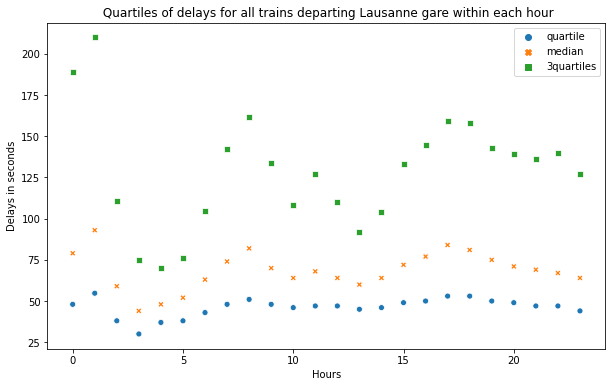

In [681]:
f, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data = df_dep_delay_lau_hour[['quartile','median','3quartiles']], ax= ax)
plt.title(" Quartiles of delays for all trains departing Lausanne gare within each hour")
plt.xlabel('Hours')
plt.ylabel('Delays in seconds')
plt.show()

**One can distinguish 2 peaks when looking at the quartiles and the sum of the delays. These two peaks happen approximately around 8 a.m and 5 p.m, something again logical since it respectively matches the beginning and end of a working day.**

iv) Did you notice something "strange"? Can you try to find the reasons behind that? Feel free to check it out from different perspectives.

**Strangely we notice that the third quartile at midnight and 1 a.m is relatively high which is odd for these hours of the day.**

**We decide to investigate more closely by counting the number of delays their cumulative sums.**

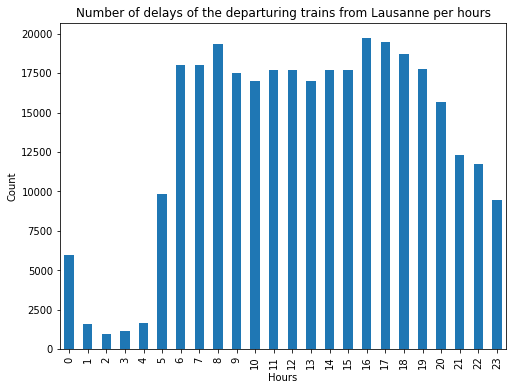

In [680]:
df_dep_delay_lau_hour[['counts']].plot(kind= 'bar', figsize = (8,6), legend = False)
plt.title("Number of delays of the departuring trains from Lausanne per hours")
plt.xlabel('Hours')
plt.ylabel("Count")
plt.show()

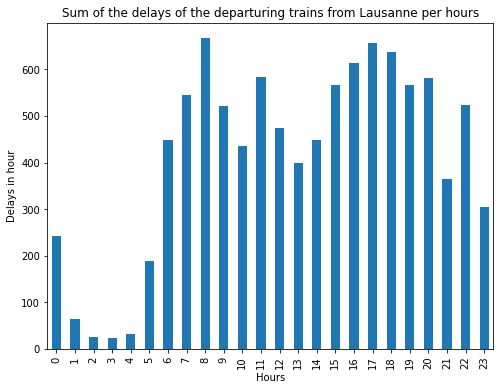

In [679]:
(df_dep_delay_lau_hour[['delays']] / 3600).plot(kind= 'bar', figsize = (8,6), legend = False)
plt.title("Sum of the delays of the departuring trains from Lausanne per hours")
plt.xlabel('Hours')
plt.ylabel("Delays in hour")
plt.show()

**We can notice that for this time slot, the number of delayed trains is very low compared to the rest of the day. Therefore, if a train has a big delay as an outlier it will impact more the percentiles than the same delay with a bigger sample.**

**We can also imagine that the trains at these hours could correspond to last trains of the day for many destinations, which make them more crowded and thus potentially more delayed.**

### Question I.f - 15 Points

If the departure time of one train is delayed, can it catch up with the schedule at a later station? Select __at least 2 trains from Genève (main station) to Lausanne gare__ as examples. Think about what kind of trains you want to select, direct or indirect (having stops in between), at rush hour or in midnight? Use HiveQL to select relevant data and show the results with a proper plot of arrival delay at Lausanne versus departure delay at Genève. Document and discuss your findings.

__Note__: you can write some helper functions to generate the query for you.

In [242]:
query = """
    drop table if exists {0}.sbb_gnv_del_orc
""".format(username)
cur.execute(query)

# Delayed trains departing Genève
query = """
    create table {0}.sbb_gnv_del_orc
    stored as orc
    as
        select * 
        from {0}.sbb_orc
        where lower(PRODUKT_ID) like 'zug' and HALTESTELLEN_NAME like 'Genève' 
        and  AB_PROGNOSE > ABFAHRTSZEIT
""".format(username)
cur.execute(query)

In [243]:
query = """
    drop table if exists {0}.sbb_lau_del_orc
""".format(username)
cur.execute(query)

# Trains arriving in Lausanne on time
query = """
    create table {0}.sbb_lau_del_orc
    stored as orc
    as
        select *
        from {0}.sbb_orc
        where lower(PRODUKT_ID) like 'zug' and HALTESTELLEN_NAME like 'Lausanne' 
        and  AB_PROGNOSE == ABFAHRTSZEIT
""".format(username)
cur.execute(query)

In [244]:
# Trains from Genève to Lausanne which could catch up the departure delay
query = """
    select distinct GNV.LINIEN_ID as line,
    lower(GNV.VERKEHRSMITTEL_TEXT) as train_type
    from {0}.sbb_gnv_del_orc GNV join {0}.sbb_lau_del_orc as LAU
    on (GNV.FAHRT_BEZEICHNER = LAU.FAHRT_BEZEICHNER)
    and GNV.AB_PROGNOSE < LAU.AN_PROGNOSE 
    and GNV.BETRIEBSTAG = LAU.BETRIEBSTAG
""".format(username)

df_gnv_to_lau = pd.read_sql(query, conn )
df_gnv_to_lau

,line,train_type
0,1721,ir
1,1723,ir
2,1733,ir
3,1809,ir
4,1813,ir
...,...,...
177,725,ic
178,729,ic
179,733,ic
180,737,ic


In [245]:
df_gnv_to_lau.line.value_counts()

3129     2
3121     2
3123     2
3125     2
3119     2
        ..
1729     1
2519     1
18469    1
18445    1
3201     1
Name: line, Length: 169, dtype: int64

**The train number *31685* succeeded to catch up three times so it's interesting to investigate it.**

### Train 31685

In [254]:
query = """
    drop table if exists {0}.sbb_31685_orc
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_31685_orc
    stored as orc
    as
        select 
        VERKEHRSMITTEL_TEXT as type,
        ZUSATZFAHRT_TF as special,
        HALTESTELLEN_NAME as stop,
        ANKUNFTSZEIT as expected_arrival,
        AN_PROGNOSE as actual_arrival,
        greatest(unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm'), 0) as arrival_delay,
        ABFAHRTSZEIT as expected_departure,
        AB_PROGNOSE as actual_departure,
        greatest(unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'), 0) as departure_delay,
        BETRIEBSTAG as day
        
        from {0}.sbb_orc
        where LINIEN_ID like 31685 
""".format(username)
cur.execute(query)

In [255]:
query = """
        select  *
        from {0}.sbb_31685_orc
        where stop like 'Genève'
""".format(username)
df_31685_gnv=pd.read_sql(query, conn )

In [246]:
df_31685_gnv

,sbb_31685_orc.type,sbb_31685_orc.special,sbb_31685_orc.stop,sbb_31685_orc.expected_arrival,sbb_31685_orc.actual_arrival,sbb_31685_orc.arrival_delay,sbb_31685_orc.expected_departure,sbb_31685_orc.actual_departure,sbb_31685_orc.departure_delay,sbb_31685_orc.day
0,IR,true,Genève,15.09.2018 16:27,15.09.2018 16:27:40,40.0,,,NaN,15.09.2018
1,EXT,true,Genève,30.09.2018 16:38,30.09.2018 16:42:38,278.0,,,NaN,30.09.2018
2,IC,true,Genève,22.10.2019 20:12,22.10.2019 20:12:09,9.0,,,NaN,22.10.2019
3,EXT,true,Genève,30.10.2018 12:39,30.10.2018 12:39:57,57.0,,,NaN,30.10.2018
4,S,true,Genève,16.12.2019 01:21,16.12.2019 01:21:54,54.0,,,NaN,15.12.2019
5,IC,true,Genève,04.11.2019 19:39,04.11.2019 19:41:32,152.0,04.11.2019 19:42,04.11.2019 19:44:20,140.0,04.11.2019
6,IC,true,Genève,22.11.2018 21:09,,NaN,,,NaN,22.11.2018
7,IR,true,Genève,13.07.2018 12:27,13.07.2018 12:29:51,171.0,,,NaN,13.07.2018
8,IC,true,Genève,05.10.2018 20:39,05.10.2018 20:39:57,57.0,,,NaN,05.10.2018
9,RE,true,Genève,12.04.2018 00:14,12.04.2018 00:20:04,364.0,12.04.2018 00:18,12.04.2018 00:22:09,249.0,11.04.2018


**This is a special line of train. From the 13 times that it stopped in Geneva, it was the terminal. In the other three stops it had a delayed departure. In one case the trip started from Geneva. In the other two Geneva was a stop and the delay in the departure is less than the delay in the arrival. So the train is catching up its delay, let's see what it does in the other stops for those trips.**

In [256]:
query = """
        select  *
        from {0}.sbb_31685_orc
        where day like '04.11.2019' or day like '11.04.2018' or day like '12.09.2018'
        order by day
""".format(username)
df_31685_del=pd.read_sql(query, conn )

In [247]:
df_31685_del

,sbb_31685_orc.type,sbb_31685_orc.special,sbb_31685_orc.stop,sbb_31685_orc.expected_arrival,sbb_31685_orc.actual_arrival,sbb_31685_orc.arrival_delay,sbb_31685_orc.expected_departure,sbb_31685_orc.actual_departure,sbb_31685_orc.departure_delay,sbb_31685_orc.day
0,IC,true,Genève-Aéroport,,,NaN,04.11.2019 19:32,04.11.2019 19:35:34,214.0,04.11.2019
1,IC,true,Genève,04.11.2019 19:39,04.11.2019 19:41:32,152.0,04.11.2019 19:42,04.11.2019 19:44:20,140.0,04.11.2019
2,IC,true,Lausanne,04.11.2019 20:18,04.11.2019 20:18:49,49.0,,,NaN,04.11.2019
3,RE,true,Genève-Aéroport,,,NaN,12.04.2018 00:07,12.04.2018 00:14:30,450.0,11.04.2018
4,RE,true,Genève,12.04.2018 00:14,12.04.2018 00:20:04,364.0,12.04.2018 00:18,12.04.2018 00:22:09,249.0,11.04.2018
5,RE,true,Coppet,12.04.2018 00:26,12.04.2018 00:33:26,446.0,12.04.2018 00:27,12.04.2018 00:34:56,476.0,11.04.2018
6,RE,true,Nyon,12.04.2018 00:33,12.04.2018 00:40:28,448.0,12.04.2018 00:34,12.04.2018 00:41:26,446.0,11.04.2018
7,RE,true,Gland,12.04.2018 00:37,12.04.2018 00:44:26,446.0,12.04.2018 00:39,12.04.2018 00:45:04,364.0,11.04.2018
8,RE,true,Rolle,12.04.2018 00:43,12.04.2018 00:48:59,359.0,12.04.2018 00:44,12.04.2018 00:49:44,344.0,11.04.2018
9,RE,true,Allaman,12.04.2018 00:47,12.04.2018 00:52:47,347.0,12.04.2018 00:49,12.04.2018 00:53:44,284.0,11.04.2018


**With further investigation, we see that :**
   *  **12.09.2018** : This trip was a direct trip (EC) from Geneva to Lausanne that started at 13h41 with a 125 seconds delay and ended with a 5 seconds delay
   * **11.04.2018** : This trip had many stops in between (RE with 7 stops). It started at 00h22 with a 249 seconds delay and ended with 486 seconds delay
   * **04.11.2019** : This trip was a direct trip (IC) from Geneva to Lausanne that started at 19h44 with a 140 seconds delay and ended with a 49 seconds delay

In [257]:
query = """
        select  *
        from {0}.sbb_31685_orc
        where (day like '04.11.2019' or day like '11.04.2018' or day like '12.09.2018')
        and (stop like 'Genève' or stop like 'Lausanne')
        order by day
""".format(username)
df_31685_del_gnv_lau=pd.read_sql(query, conn )

In [248]:
df_31685_del_gnv_lau

,sbb_31685_orc.type,sbb_31685_orc.special,sbb_31685_orc.stop,sbb_31685_orc.expected_arrival,sbb_31685_orc.actual_arrival,sbb_31685_orc.arrival_delay,sbb_31685_orc.expected_departure,sbb_31685_orc.actual_departure,sbb_31685_orc.departure_delay,sbb_31685_orc.day
0,IC,true,Genève,04.11.2019 19:39,04.11.2019 19:41:32,152.0,04.11.2019 19:42,04.11.2019 19:44:20,140.0,04.11.2019
1,IC,true,Lausanne,04.11.2019 20:18,04.11.2019 20:18:49,49.0,,,NaN,04.11.2019
2,RE,true,Genève,12.04.2018 00:14,12.04.2018 00:20:04,364.0,12.04.2018 00:18,12.04.2018 00:22:09,249.0,11.04.2018
3,RE,true,Lausanne,12.04.2018 01:08,12.04.2018 01:16:06,486.0,,,NaN,11.04.2018
4,EC,true,Genève,,,NaN,12.09.2018 13:39,12.09.2018 13:41:05,125.0,12.09.2018
5,EC,true,Lausanne,12.09.2018 14:15,12.09.2018 14:15:05,5.0,,,NaN,12.09.2018


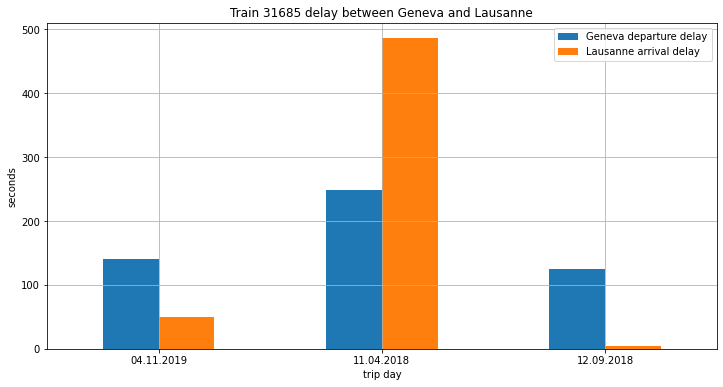

In [249]:
gnv_dep=df_31685_del_gnv_lau[df_31685_del_gnv_lau["sbb_31685_orc.stop"]=="Genève"][[
            "sbb_31685_orc.departure_delay","sbb_31685_orc.day"]]
lau_arr=df_31685_del_gnv_lau[df_31685_del_gnv_lau["sbb_31685_orc.stop"]=="Lausanne"][[
            "sbb_31685_orc.arrival_delay","sbb_31685_orc.day"]]
preplot=pd.merge(gnv_dep,lau_arr,on="sbb_31685_orc.day")
preplot.columns=["Geneva departure delay","trip day","Lausanne arrival delay"]
preplot.set_index("trip day",inplace=True)
plt
preplot.plot.bar(rot=0,title="Train 31685 delay between Geneva and Lausanne",figsize=(12,6),grid=True)
_=plt.ylabel("seconds")

**The second trip is the most interesting since it accumalated delay and had many stops in between.**

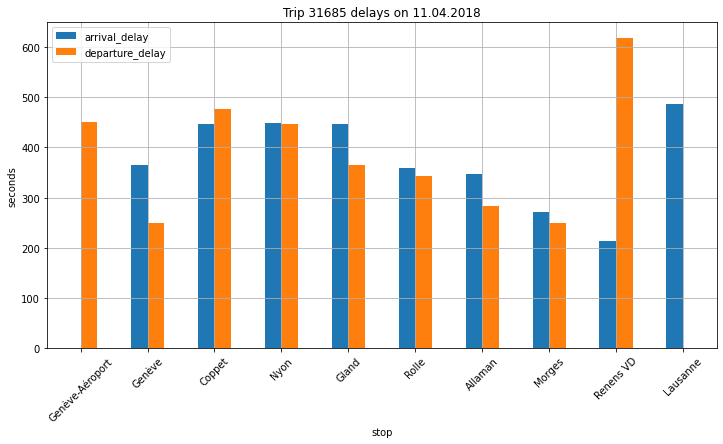

In [250]:
re_trip=df_31685_del[df_31685_del["sbb_31685_orc.type"]=="RE"][["sbb_31685_orc.stop","sbb_31685_orc.arrival_delay","sbb_31685_orc.departure_delay"]]
re_trip.columns=["stop","arrival_delay","departure_delay"]
re_trip.set_index("stop",inplace=True)
re_trip.plot.bar(rot=45,figsize=(12,6),title="Trip 31685 delays on 11.04.2018",grid=True)
_=plt.ylabel("seconds")

**We see that the general trend is that the delay shrinks between stops (especially between Coppet and Morges) which is due to a shorter stoppage time at the stations. But then strangely it got delayed a lot at Renens (almost 7 mins) even though it was at 1 a.m at that time so there shouldn't be that much traffic.**

### Train 31687

In [258]:
query = """
    drop table if exists {0}.sbb_31687_orc
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_31687_orc
    stored as orc
    as
        select 
        VERKEHRSMITTEL_TEXT as type,
        ZUSATZFAHRT_TF as special,
        HALTESTELLEN_NAME as stop,
        ANKUNFTSZEIT as expected_arrival,
        AN_PROGNOSE as actual_arrival,
        greatest(unix_timestamp(AN_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ANKUNFTSZEIT, 'dd.MM.yyy HH:mm'), 0) as arrival_delay,
        ABFAHRTSZEIT as expected_departure,
        AB_PROGNOSE as actual_departure,
        greatest(unix_timestamp(AB_PROGNOSE, 'dd.MM.yyy HH:mm:ss') - unix_timestamp(ABFAHRTSZEIT, 'dd.MM.yyy HH:mm'), 0) as departure_delay,
        BETRIEBSTAG as day
        
        from {0}.sbb_orc
        where LINIEN_ID like 31687 
""".format(username)
cur.execute(query)

In [259]:
query = """
        select  *
        from {0}.sbb_31687_orc
        where stop like 'Genève'
""".format(username)
df_31687_gnv=pd.read_sql(query, conn )

In [251]:
df_31687_gnv

,sbb_31687_orc.type,sbb_31687_orc.special,sbb_31687_orc.stop,sbb_31687_orc.expected_arrival,sbb_31687_orc.actual_arrival,sbb_31687_orc.arrival_delay,sbb_31687_orc.expected_departure,sbb_31687_orc.actual_departure,sbb_31687_orc.departure_delay,sbb_31687_orc.day
0,RE,true,Genève,,,NaN,03.09.2018 18:16,03.09.2018 18:17:40,100.0,03.09.2018
1,EXT,true,Genève,07.11.2019 20:39,07.11.2019 20:38:48,0.0,,,NaN,07.11.2019
2,EXT,true,Genève,16.01.2019 20:39,16.01.2019 20:38:43,0.0,,,NaN,16.01.2019
3,IR,true,Genève,,,NaN,08.07.2018 15:00,08.07.2018 15:02:24,144.0,08.07.2018
4,EXT,true,Genève,,,NaN,30.10.2018 12:20,30.10.2018 12:21:17,77.0,30.10.2018
5,EXT,true,Genève,21.11.2018 13:39,21.11.2018 13:41:31,151.0,,,NaN,21.11.2018
6,IC,true,Genève,21.06.2018 20:39,21.06.2018 21:09:08,1808.0,21.06.2018 20:42,21.06.2018 21:23:32,2492.0,21.06.2018
7,EXT,true,Genève,,,NaN,11.06.2018 17:05,11.06.2018 17:56:42,3102.0,11.06.2018
8,EXT,true,Genève,19.10.2018 14:12,19.10.2018 14:14:02,122.0,,,NaN,19.10.2018
9,IR,true,Genève,,,NaN,05.09.2018 15:03,05.09.2018 15:04:57,117.0,05.09.2018


**Let's focus on the trips that had a delayed departure from Geneva.**

In [262]:
df_31687_gnv_del=df_31687_gnv[df_31687_gnv["sbb_31687_orc.departure_delay"]>0]

In [261]:
query = """ 
        select  *
        from {0}.sbb_31687_orc
        where stop like 'Lausanne'
        
""".format(username)
df_31687_lau=pd.read_sql(query, conn )

In [271]:
intersection=pd.merge(df_31687_gnv_del,df_31687_lau,how="inner",on="sbb_31687_orc.day")
intersection

,sbb_31687_orc.type_x,sbb_31687_orc.special_x,sbb_31687_orc.stop_x,sbb_31687_orc.expected_arrival_x,sbb_31687_orc.actual_arrival_x,sbb_31687_orc.arrival_delay_x,sbb_31687_orc.expected_departure_x,sbb_31687_orc.actual_departure_x,sbb_31687_orc.departure_delay_x,sbb_31687_orc.day,sbb_31687_orc.type_y,sbb_31687_orc.special_y,sbb_31687_orc.stop_y,sbb_31687_orc.expected_arrival_y,sbb_31687_orc.actual_arrival_y,sbb_31687_orc.arrival_delay_y,sbb_31687_orc.expected_departure_y,sbb_31687_orc.actual_departure_y,sbb_31687_orc.departure_delay_y
0,RE,true,Genève,,,NaN,03.09.2018 18:16,03.09.2018 18:17:40,100.0,03.09.2018,RE,true,Lausanne,03.09.2018 19:06,03.09.2018 19:05:34,0.0,,,NaN
1,IR,true,Genève,,,NaN,08.07.2018 15:00,08.07.2018 15:02:24,144.0,08.07.2018,IR,true,Lausanne,08.07.2018 15:42,08.07.2018 15:43:03,63.0,,,NaN
2,EXT,true,Genève,,,NaN,11.06.2018 17:05,11.06.2018 17:56:42,3102.0,11.06.2018,EXT,true,Lausanne,11.06.2018 17:51,11.06.2018 18:46:39,3339.0,11.06.2018 17:56,11.06.2018 18:50:59,3299.0
3,IC,true,Genève,21.06.2018 20:39,21.06.2018 21:09:08,1808.0,21.06.2018 20:42,21.06.2018 21:23:32,2492.0,21.06.2018,IC,true,Lausanne,21.06.2018 21:18,21.06.2018 22:27:15,4155.0,21.06.2018 21:20,21.06.2018 22:34:58,4498.0


In [272]:
intersection["sbb_31687_orc.day"]

0    03.09.2018
1    08.07.2018
2    11.06.2018
3    21.06.2018
Name: sbb_31687_orc.day, dtype: object

**These are the dates where this line passed by both Geneva and Lausanne.**

In [265]:
query = """
    drop table if exists {0}.sbb_31687_del_orc
""".format(username)
cur.execute(query)

query = """
    create table {0}.sbb_31687_del_orc
    stored as orc
    as
        select *
        from {0}.sbb_31687_orc
        where day like '11.06.2018' or day like '21.06.2018' or day like '03.09.2018' or day like '08.07.2018'
        order by day ,actual_arrival
""".format(username)
cur.execute(query)

In [266]:
query = """
    select *
    from {0}.sbb_31687_del_orc
""".format(username)

df_31687_del = pd.read_sql(query, conn )

In [269]:
df_31687_del[df_31687_del["sbb_31687_del_orc.stop"]=="Lausanne"]

,sbb_31687_del_orc.type,sbb_31687_del_orc.special,sbb_31687_del_orc.stop,sbb_31687_del_orc.expected_arrival,sbb_31687_del_orc.actual_arrival,sbb_31687_del_orc.arrival_delay,sbb_31687_del_orc.expected_departure,sbb_31687_del_orc.actual_departure,sbb_31687_del_orc.departure_delay,sbb_31687_del_orc.day
8,RE,true,Lausanne,03.09.2018 19:06,03.09.2018 19:05:34,0.0,,,NaN,03.09.2018
12,IR,true,Lausanne,08.07.2018 15:42,08.07.2018 15:43:03,63.0,,,NaN,08.07.2018
16,EXT,true,Lausanne,11.06.2018 17:51,11.06.2018 18:46:39,3339.0,11.06.2018 17:56,11.06.2018 18:50:59,3299.0,11.06.2018
25,IC,true,Lausanne,21.06.2018 21:18,21.06.2018 22:27:15,4155.0,21.06.2018 21:20,21.06.2018 22:34:58,4498.0,21.06.2018


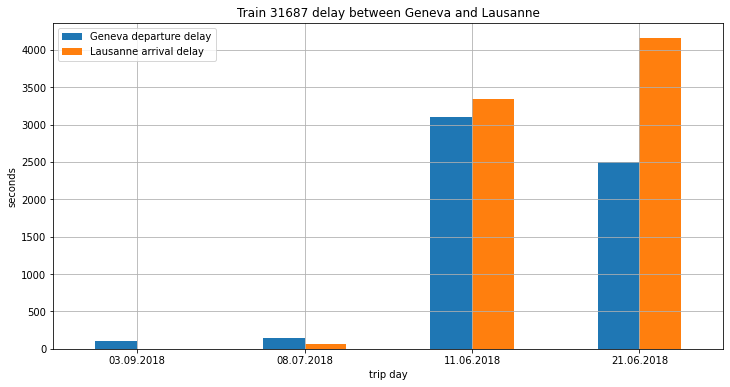

In [270]:
gnv_dep=df_31687_del[df_31687_del["sbb_31687_del_orc.stop"]=="Genève"][[
            "sbb_31687_del_orc.departure_delay","sbb_31687_del_orc.day"]]
lau_arr=df_31687_del[df_31687_del["sbb_31687_del_orc.stop"]=="Lausanne"][[
            "sbb_31687_del_orc.arrival_delay","sbb_31687_del_orc.day"]]
preplot=pd.merge(gnv_dep,lau_arr,on="sbb_31687_del_orc.day")
preplot.columns=["Geneva departure delay","trip day","Lausanne arrival delay"]
preplot.set_index("trip day",inplace=True)
plt
preplot.plot.bar(rot=0,title="Train 31687 delay between Geneva and Lausanne",figsize=(12,6),grid=True)
_=plt.ylabel("seconds")

**The first two trips had a an insignificant delay compared to the last two. In the first one (03/09/2018) the train managed to catch up and arrive at time to Lausanne. In the second (08/07/2018) the train reduced the delay from 144s to 63s. 
Now let's focus on the last two.**

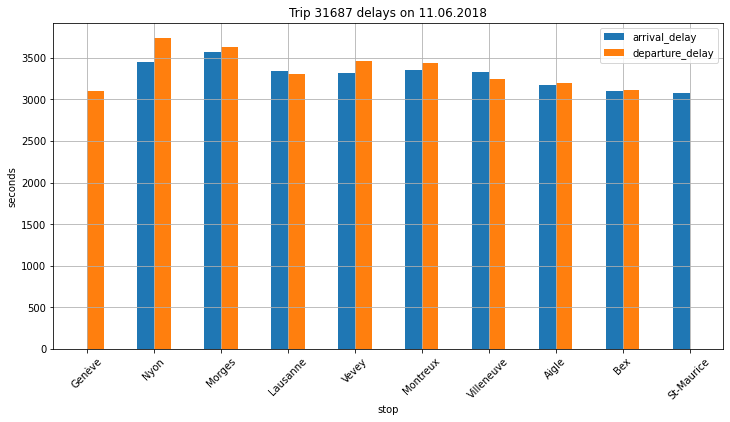

In [273]:
ext_trip=df_31687_del[df_31687_del["sbb_31687_del_orc.type"]=="EXT"][["sbb_31687_del_orc.stop","sbb_31687_del_orc.arrival_delay","sbb_31687_del_orc.departure_delay"]]
ext_trip.columns=["stop","arrival_delay","departure_delay"]
ext_trip.set_index("stop",inplace=True)
ext_trip.plot.bar(rot=45,figsize=(12,6),title="Trip 31687 delays on 11.06.2018",grid=True)
_=plt.ylabel("seconds")

  *  **11.06.2018** : This trip was of type EXT which has one stop (Morges) from Geneva to Lausanne that started at 17h56 with a 3102 seconds delay (almost an hour!) and ended with a 3339 seconds delay. The delay managed to shrink by almost 5 mins after 7 stops to reach St-Maurice with a 3074 seconds delay. It's interesting to mention that this day witnessed extreme floodings in the area
 

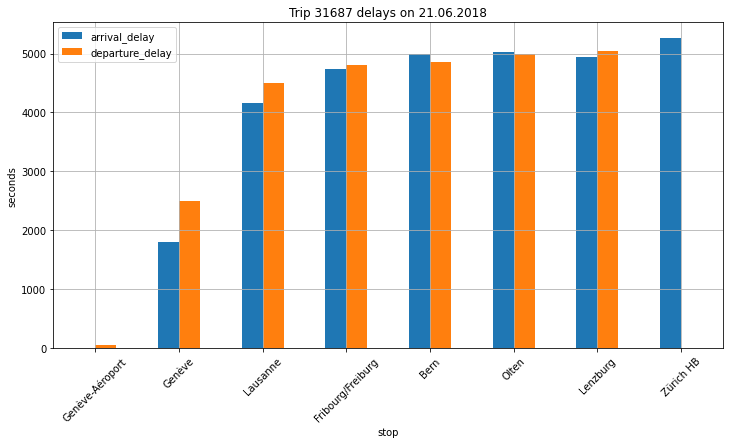

In [274]:
ic_trip=df_31687_del[df_31687_del["sbb_31687_del_orc.type"]=="IC"][["sbb_31687_del_orc.stop","sbb_31687_del_orc.arrival_delay","sbb_31687_del_orc.departure_delay"]]
ic_trip.columns=["stop","arrival_delay","departure_delay"]
ic_trip.set_index("stop",inplace=True)
ic_trip.plot.bar(rot=45,figsize=(12,6),title="Trip 31687 delays on 21.06.2018",grid=True)
_=plt.ylabel("seconds")

 * **21.06.2018** : This trip was a direct trip (IC) from Geneva to Lausanne that started at 21h23 with a 2492 seconds delay and arrived at Lausanne with a 4155 seconds delay. This disturbance in traffic might be explained with the fact that the pope came to Geneva that day (and also caused some disturbance in the airport)

**As a conclusion, there could be different outcomes to a departure delay and the train can catch it up or not depending on the circumstances.** 